In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import warnings
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder, OneHotEncoder, PowerTransformer
from sklearn.model_selection import train_test_split, StratifiedKFold
# from sklearn.feature_selection import SelectKBest, chi2, f_classif, RFE, MutualInfoClassifier
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer

In [13]:
# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Plot styling
plt.style.use('ggplot')
sns.set_palette("husl")

# Define Column Names for NSL-KDD (Standard List)
COL_NAMES = ["duration","protocol_type","service","flag","src_bytes",
    "dst_bytes","land","wrong_fragment","urgent","hot","num_failed_logins",
    "logged_in","num_compromised","root_shell","su_attempted","num_root",
    "num_file_creations","num_shells","num_access_files","num_outbound_cmds",
    "is_host_login","is_guest_login","count","srv_count","serror_rate",
    "srv_serror_rate","rerror_rate","srv_rerror_rate","same_srv_rate",
    "diff_srv_rate","srv_diff_host_rate","dst_host_count","dst_host_srv_count",
    "dst_host_same_srv_rate","dst_host_diff_srv_rate","dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate",
    "dst_host_rerror_rate","dst_host_srv_rerror_rate","label", "difficulty_level"]

In [16]:

# Load Data (Assuming data is in ../SentinelNet/data or ../data relative to notebook)
# You might need to adjust the path based on your exact folder structure
train_path = './data/KDDTrain+.txt'
test_path = './data/KDDTest+.txt'

# Try loading with error handling for paths
try:
    df_train = pd.read_csv(train_path, header=None, names=COL_NAMES)
    df_test = pd.read_csv(test_path, header=None, names=COL_NAMES)
    print(f"Training Data Shape: {df_train.shape}")
    print(f"Test Data Shape: {df_test.shape}")
except FileNotFoundError:
    print("Files not found. Please check the paths. Trying absolute paths or checking local directory...")
    # Fallback to local directory if paths are different
    if os.path.exists('KDDTrain+.txt'):
        df_train = pd.read_csv('KDDTrain+.txt', header=None, names=COL_NAMES)
        df_test = pd.read_csv('KDDTest+.txt', header=None, names=COL_NAMES)

# Combine for initial analysis (optional, but good for understanding full global distributions)
# We will split back later to avoid data leakage.
# For rigorous preprocessing, we fit on TRAIN and transform TEST.


Training Data Shape: (125973, 43)
Test Data Shape: (22544, 43)


In [17]:

# Separate Target Variable
# 'label' is the attack type, 'difficulty_level' is specific to NSL-KDD (we usually drop difficulty for training)

# Define feature groups
categorical_features = ['protocol_type', 'service', 'flag']
binary_features = ['land', 'logged_in', 'is_host_login', 'is_guest_login']
# All others are numerical
numerical_features = [col for col in COL_NAMES if col not in categorical_features + binary_features + ['label', 'difficulty_level']]

print(f"Categorical Features: {len(categorical_features)}")
print(f"Binary Features: {len(binary_features)}")
print(f"Numerical Features: {len(numerical_features)}")

# Check for nulls
print("\nMissing Values in Train:")
print(df_train.isnull().sum().sum())


Categorical Features: 3
Binary Features: 4
Numerical Features: 34

Missing Values in Train:
0


In [18]:

# Mapping Dictionary
attack_mapping = {
    'normal': 'normal',
    
    # DoS
    'back': 'DoS', 'land': 'DoS', 'neptune': 'DoS', 'pod': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 'mailbomb': 'DoS', 'apache2': 'DoS', 'processtable': 'DoS', 'udpstorm': 'DoS',
    
    # Probe
    'satan': 'Probe', 'ipsweep': 'Probe', 'nmap': 'Probe', 'portsweep': 'Probe', 'mscan': 'Probe', 'saint': 'Probe',
    
    # R2L
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L', 'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L', 'snmpguess': 'R2L', 'snmpgetattack': 'R2L', 'httptunnel': 'R2L', 'sendmail': 'R2L', 'named': 'R2L',
    
    # U2R
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'perl': 'U2R', 'rootkit': 'U2R', 'ps': 'U2R', 'xterm': 'U2R', 'sqlattack': 'U2R'
}

# Apply mapping
df_train['attack_class'] = df_train['label'].map(lambda x: attack_mapping.get(x, 'other'))
df_test['attack_class'] = df_test['label'].map(lambda x: attack_mapping.get(x, 'other'))

print("Training Class Distribution:")
print(df_train['attack_class'].value_counts())


Training Class Distribution:
attack_class
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64


Identified 1256 outliers using Isolation Forest.


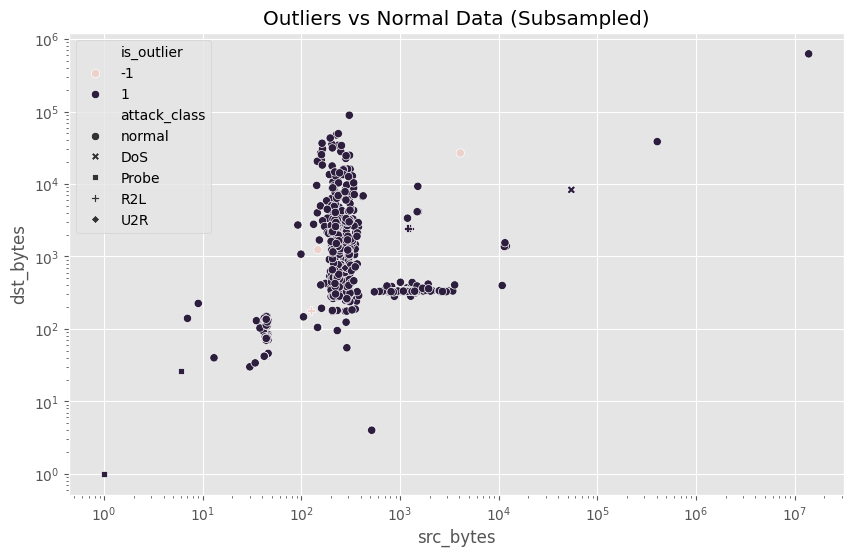

In [25]:

def clean_outliers_isolation_forest(df, contamination=0.01):
    # Select only numerical features for outlier detection
    # We copy to avoid setting slice warnings
    iso_df = df[numerical_features].copy()
    
    # Initialize Isolation Forest
    clf = IsolationForest(max_samples='auto', contamination=contamination, random_state=42)
    
    # Fit and Predict
    outliers = clf.fit_predict(iso_df) # Returns -1 for outliers, 1 for inliers
    
    # Count
    n_outliers = (outliers == -1).sum()
    print(f"Identified {n_outliers} outliers using Isolation Forest.")
    
    # We can either drop them or flag them. For this exercise, we will FLAG them as a new feature.
    # Dropping outliers in Security datasets is dangerous because attacks ARE outliers often!
    # A safer approach is adding an 'is_statistical_outlier' feature.
    
    return outliers

df_train['is_outlier'] = clean_outliers_isolation_forest(df_train)

# Visualize an outlier feature interaction
plt.figure(figsize=(10,6))
sns.scatterplot(data=df_train[::100], x='src_bytes', y='dst_bytes', hue='is_outlier', style='attack_class')
plt.title("Outliers vs Normal Data (Subsampled)")
plt.xscale('log')
plt.yscale('log')
plt.show()
